# Validation comparing queried articles with random articles

### Sagar Setru

How reliable is using words in topics as query words?

To test this, I will compare the Jaccard similarity between words in topics of a set of queried articles to random articles.

In [1]:
# make sure I'm in the right environment (should be 'debiaser')
import os
print('Conda environment:')
print(os.environ['CONDA_DEFAULT_ENV'])

Conda environment:
debiaser


In [2]:
# add parent directory to path 

import sys
sys.path.append(os.path.dirname(os.getcwd()))

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import json

# NLP Packages
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# to break articles up into sentences
from nltk import tokenize

import pyLDAvis
import pyLDAvis.gensim

import pickle

# from debiaser_validation_function import return_suggested_articles2
from debiaser.debiaser_validation_function import return_suggested_articles2
from debiaser.debiaser_validation_function import get_jaccard_sim
# from text_processing_functions import process_all_articles
# from text_processing_functions import remove_stopwords
# from text_processing_functions import get_simple_corpus_dictionary_bow
# from text_processing_functions import entity_recognizer
# from text_processing_functions import get_topic_words_mean_std_prob_frequency
# from text_processing_functions import sort_topics_mean_frequency

import pickle
print('DONE')

DONE


In [10]:
# print queries for searching headline

all_sides_with_domains = pd.read_csv('../all_sides_media_data/allsides_final_plus_others_with_domains.csv')
all_sides_domains = all_sides_with_domains['domain']
headline = 'White House Blocked C.D.C. Order to Keep Cruise Ships Docked'

for domain in all_sides_domains:
    print('site:'+domain+' '+headline)
    

site:abcnews.go.com White House Blocked C.D.C. Order to Keep Cruise Ships Docked
site:aljazeera.com White House Blocked C.D.C. Order to Keep Cruise Ships Docked
site:apnews.com White House Blocked C.D.C. Order to Keep Cruise Ships Docked
site:bbc.com White House Blocked C.D.C. Order to Keep Cruise Ships Docked
site:bloomberg.com White House Blocked C.D.C. Order to Keep Cruise Ships Docked
site:breitbart.com White House Blocked C.D.C. Order to Keep Cruise Ships Docked
site:buzzfeednews.com White House Blocked C.D.C. Order to Keep Cruise Ships Docked
site:cbn.com White House Blocked C.D.C. Order to Keep Cruise Ships Docked
site:cbsnews.com White House Blocked C.D.C. Order to Keep Cruise Ships Docked
site:csmonitor.com White House Blocked C.D.C. Order to Keep Cruise Ships Docked
site:cnn.com White House Blocked C.D.C. Order to Keep Cruise Ships Docked
site:thedailybeast.com White House Blocked C.D.C. Order to Keep Cruise Ships Docked
site:democracynow.org White House Blocked C.D.C. Order 

/Users/sagarsetru/anaconda3/envs/debiaser/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [51]:
# these were identified with 5 words

# list of main urls
url_main = [
    'https://www.nytimes.com/2020/09/30/health/covid-cruise-ships.html'
]

urls_queried = [
    'https://abcnews.go.com/Health/wireStory/crew-member-cruise-ship-virus-cases-dies-florida-70073196',
    'https://abcnews.go.com/International/wireStory/german-cruise-ship-sets-sail-hopes-short-trip-71986996',
    'https://apnews.com/article/dbc1f2f76ec33ad06d0a78c4ca3e774a',
    'https://apnews.com/article/ap-top-news-travel-international-news-changing-economy-travel-e9878e281e71d58a6bd4e7f88a24797d',
    'https://www.breitbart.com/news/german-cruise-ship-sets-sail-hopes-short-trip-thwarts-virus/',
    'https://www.forbes.com/sites/alexledsom/2020/09/30/white-house-blocks-cdcs-idea-to-extend-no-sail-order-until-feb-2021/#3e2381e73e42',
    'https://www.foxnews.com/travel/cdc-extends-no-sail-order-cruise-ships-coronavirus-crisis',
    'https://www.foxnews.com/travel/zaandam-cruise-ship-fourth-person-coronavirus-dies',
    'https://www.theguardian.com/us-news/2020/oct/01/florida-keys-cruise-ship-ban-covid-19',
    'https://thehill.com/policy/transportation/518975-white-house-blocked-extending-no-sail-cruise-ship-order-until-february',
    'https://thehill.com/policy/healthcare/486115-second-princess-cruise-ship-with-possible-coronavirus-onboard-held-offshore',
    'https://www.nbcnews.com/health/health-news/live-blog/2020-04-09-coronavirus-news-n1179786/ncrd1180841#blogHeader',
    'https://www.nytimes.com/2020/09/30/health/covid-cruise-ships.html',
    'https://www.nytimes.com/2020/09/30/briefing/presidential-debate-cruise-ships-nba.html',
    'https://www.newsmax.com/world/globaltalk/germany-virus-outbreak-cruises/2020/07/25/id/979000/',
    'https://www.npr.org/sections/coronavirus-live-updates/2020/10/01/919082224/the-cdc-extends-no-sail-order-for-cruise-lines',
    'https://www.npr.org/sections/coronavirus-live-updates/',
    'https://reason.com/video/how-china-corrupted-the-world-health-organizations-response-to-covid-19/',
    'https://www.salon.com/2020/10/17/inside-the-fall-of-the-cdc_partner/'
]

urls_random = [
    'https://abcnews.go.com/Health/wireStory/australia-expects-covid-19-vaccination-year-73467063',
    'https://abcnews.go.com/Politics/wireStory/questions-pence-harris-prepare-debate-faceoff-73458831',
    'https://www.aljazeera.com/news/2020/10/26/pakistan-accuses-macron-of-encouraging',
    'https://www.aljazeera.com/news/2020/10/26/senate-set-to-confirm-amy-coney-barrett-us-election-live-news',
    'https://www.theatlantic.com/health/archive/2020/10/pandemic-safety-america/616858/',
    'https://www.theatlantic.com/ideas/archive/2020/10/hate-wokeness-vote-biden/616845/',
    'https://www.cbsnews.com/news/tropical-storm-zeta-hurricane-strength-gulf-coast-landfall/',
    'https://www.cbsnews.com/news/us-covid-19-cases-testing/',
    'https://www.democracynow.org/2020/10/26/headlines/gop_ruled_senate_set_to_confirm_amy_coney_barrett_trumps_third_scotus_justice',
    'https://www.democracynow.org/2020/10/26/headlines/illinois_public_health_official_breaks_down_in_tears_while_reporting_coronavirus_toll',
    'https://apnews.com/article/election-2020-virus-outbreak-joe-biden-donald-trump-campaigns-3e201de86931e092efb31de0284ed67e',
    'https://www.huffpost.com/entry/covid-updates-white-house-not-going-to-control-pandemic_n_5f96bb00c5b68dbe93f94b2a',
    'https://www.huffpost.com/entry/jared-kushner-black-lives-matter_n_5f96e7d8c5b6c942b765e257',
    'https://apnews.com/article/virus-outbreak-india-archive-economy-a6b30f224b37015e982fd557dcf522d5',
    'https://www.nationalreview.com/the-morning-jolt/what-trump-needs-to-win/',
    'https://www.breitbart.com/economy/2020/10/06/pelosi-killed-the-bill/',
    'https://www.forbes.com/sites/lanabandoim/2020/10/06/tally-the-cute-shelf-scanning-robot-is-coming-to-more-grocery-stores/#6105129e177f',
    'https://www.foxnews.com/sports/patriots-james-white-fathers-tragic-death-meant-whole-lot',
    'https://www.foxnews.com/sports/acuna-hr-plunked-again-braves-top-marlins-9-5-to-open-nlds',
    'https://thehill.com/policy/energy-environment/519909-biden-would-face-hurdles-undoing-trump-environmental-rollbacks',
    'https://thehill.com/homenews/campaign/519851-trump-biden-tied-when-it-comes-to-economy-poll',
    'https://www.nbcnews.com/news/us-news/justice-department-officials-drove-family-separation-policy-watchdog-report-says-n1242375',
    'https://www.nytimes.com/2020/10/07/nyregion/register-to-vote-nyc.html',
    'https://www.nytimes.com/2020/10/06/nyregion/graffiti-artists-5pointz.html',
    'https://www.newsmax.com/politics/stephen-miller-covid-19-testing-positive/2020/10/06/id/990703/',
    'https://www.npr.org/2020/10/07/921055011/trumps-covid-19-treatment-hangs-over-vice-presidential-debate',
    'https://www.npr.org/2020/10/06/920684113/michelle-obama-makes-final-pitch-vote-for-joe-biden-like-your-lives-depend-on-it',
    'https://reason.com/2020/10/06/eddie-van-halen-melting-pot-virtuoso/',
    'https://reason.com/2020/10/26/the-seventh-rule-of-court-packing-is-to-rule-out-term-limits-for-supreme-court-justices/',
    'https://in.reuters.com/article/us-global-markets/stocks-slide-on-surging-covid-19-cases-stimulus-doubts-dollar-rises-idINKBN27B01F',
    'https://in.reuters.com/article/usa-economy/wrapup-1-u-s-new-home-sales-fall-in-september-prices-continue-to-rise-idUSL1N2HH183',
    'https://www.salon.com/2020/10/26/top-fox-news-hosts-told-to-quarantine-ahead-of-election-day-as-covid-19-cases-hit-network/',
    'https://www.salon.com/2020/10/26/coronavirus-may-dull-the-bodys-pain-receptors-helping-unsuspecting-people-spread-it-study-says/',
    'https://www.theguardian.com/education/2020/oct/26/governments-own-advisory-committee-urges-it-to-extend-free-school-meals',
    'https://www.theguardian.com/environment/2020/oct/07/one-guy-pulled-a-crowbar-on-me-why-fly-tipping-wars-are-raging-across-britain'
]

urls_headline = [
    'https://abcnews.go.com/Health/coronavirus-live-updates-china-exonerates-whistleblower-doctor-warned/story?id=69702910',
    'https://www.aljazeera.com/news/2020/4/26/no-evidence-recovered-virus-patients-are-immune-live-updates',
    'https://www.aljazeera.com/news/2020/3/9/366-coronavirus-deaths-in-italy-saudi-schools-shut-live-updates',
    'https://www.theatlantic.com/health/archive/2020/07/why-arent-we-talking-more-about-airborne-transmission/614737/',
    'https://www.theatlantic.com/notes/2020/04/time-capsule-11-captain-crozier/609409/',
    'https://www.cbsnews.com/live-updates/coronavirus-pandemic-covid-19-latest-news-2020-04-04/',
    'https://www.cbsnews.com/live-updates/coronavirus-updates-cases-fears-deaths-us-latest-2020-03-16/',
    'https://www.democracynow.org/2020/4/3/headlines/nicaragua_resists_social_distancing_measures_as_covid_19_cases_climb',
    'https://www.democracynow.org/2020/4/3/headlines/joe_biden_joins_bernie_sanders_and_other_dem_lawmakers_calling_on_us_to_ease_iran_sanctions',
    'https://www.forbes.com/sites/elisabethbrier/2020/03/23/forbes-timeline-of-the-coronavirus/#1b8fa7ab5722',
    'https://www.foxnews.com/travel/easy-ways-to-save-money-on-a-cruise',
    'https://www.foxnews.com/travel/how-to-pick-a-cruise-line-for-safety'
    'https://www.huffpost.com/entry/covid-19-latest-news-fauci-vaccine-2020_n_5f280f70c5b68fbfc885e232',
    'https://www.huffpost.com/entry/coronavirus-pandemic-outbreak-latest-updates_n_5e699638c5b6747ef116e247',
    'https://www.nationalreview.com/the-weekend-jolt/',
    'https://www.nbcnews.com/health/health-news/live-blog/2020-04-04-coronavirus-news-n1176616',
    'https://www.npr.org/2020/03/12/814881355/white-house-knew-coronavirus-would-be-a-major-threat-but-response-fell-short',
    'https://www.npr.org/2020/03/09/813763871/president-trump-has-consistently-downplayed-threat-of-coronavirus',
    'https://reason.com/2020/04/06/white-house-recommends-against-grocery-and-pharmacy-trips-while-trump-says-go-ahead-and-try-hydroxychloroquine/',
    'https://reason.com/2020/03/11/how-government-red-tape-stymied-testing-and-made-the-coronavirus-epidemic-worse/',
    'https://www.reuters.com/article/us-health-coronavirus-usa-quarantine-idUSKBN211111',
    'https://www.reuters.com/news/picture/us-scrambles-to-prepare-for-more-coronav-idUSRTS34GDT',
    'https://www.salon.com/2020/10/17/inside-the-fall-of-the-cdc_partner/',
    'https://www.salon.com/2020/04/19/detailed-timeline-of-trumps-failures-shows-how-americas-coronavirus-crisis-was-man-made_partner/',
    'https://www.theguardian.com/us-news/live/2020/jul/16/coronavirus-us-covid-donald-trump-anthony-fauci-joe-biden-live-updates',
    'https://www.theguardian.com/world/2020/mar/09/coronavirus-us-shutdown-closures',
    'https://thehill.com/policy/transportation/518975-white-house-blocked-extending-no-sail-cruise-ship-order-until-february',
    'https://thehill.com/policy/healthcare/520454-trump-administration-kept-cdc-from-issuing-mask-requirement-on-public',
]

# no hits for queried: aljazeera, atlantic, bbc, bloomberg, buzzfeed, cbn, cbs, democracy now, factcheck, huffpost, national review, reuters, salon

# no hits for headline: AP news, bbc, bloomberg, breitbart, buzzfeed, cbn, factcheck,



# fails for nearly same event: newsmax, wsj

#     https://nypost.com/2020/04/10/cdc-extends-no-sail-order-for-all-cruises-amid-coronavirus-crisis/
#     https://nypost.com/2020/07/16/cdc-bans-us-cruises-through-september-due-to-ongoing-outbreaks-on-ships/



# text loading doesn't work well (excluded): CNN, daily beast, msnbc, nypost, spectator
# buggy (excluded): mother jones, newsmax, politico

/Users/sagarsetru/anaconda3/envs/debiaser/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
# get query words from original article
url_main_query_words = return_suggested_articles2(url_main[0])

/Users/sagarsetru/anaconda3/envs/debiaser/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AFTER STOPWORDS
[['blocked'], ['cruise', 'ships', 'docked'], [], ['sail', 'extended', 'upset', 'tourism', 'crucial', 'swing', 'florida', 'blocked', 'centers', 'disease', 'prevention', 'cruise', 'ships', 'docked', 'mid', 'displeased', 'politically', 'powerful', 'tourism', 'crucial', 'swing', 'florida', 'sail', 'originally', 'extended', 'expire'], ['robert', 'redfield', 'recommended', 'extension', 'worried', 'cruise', 'ships', 'viral', 'hot', 'spots', 'beginning', 'pandemic', 'coronavirus', 'task', 'redfield', 'overruled', 'authorized', 'spoke', 'condition', 'anonymity'], ['ships', 'sail', 'oct', 'agreed', 'voluntary'], ['rejection', 'original', 'axios'], ['redfield', 'scolded', 'promoting', 'mask', 'wearing', 'cautioning', 'vaccines', 'widely', 'worried', 'fired', 'considered', 'resigning', 'required', 'oversee', 'compromised', 'redfield', 'brian', 'morgenstern', 'deputy', 'cruise', 'ship', 'politically', 'motivated'], ['vice', 'task', 'science', 'implement', 'policies', 'protect', 'fac

In [6]:
url_main_query_words

/Users/sagarsetru/anaconda3/envs/debiaser/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(' cruise sail redfield florida virus',
 ['cruise', 'sail', 'redfield', 'florida', 'virus'])

In [8]:
# array for jaccard sim results
jaccard_sim_queried_articles = np.zeros((len(urls_queried),1))

# get jaccard sim scores between articles queried with words in topics and main article
for ind, url in enumerate(urls_queried):
    
    # get query words
    query_words = return_suggested_articles2(url,num_lda_topics=1)
    
    print(f'query words: {query_words[0]}')
    jaccard_sim = get_jaccard_sim(url_main_query_words[1],query_words[1])
        
    jaccard_sim_queried_articles[ind] = jaccard_sim
    
print('DONE')

/Users/sagarsetru/anaconda3/envs/debiaser/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AFTER STOPWORDS
[['crew', 'cruise', 'ship', 'virus', 'cases', 'dies', 'florida'], ['miami', 'crew', 'hospitalized', 'ill', 'fated', 'cruise', 'ships', 'coronavirus', 'patients', 'dock', 'florida', 'broward', 'examiner', 'craig', 'mallak', 'wiwit', 'widarto', 'indonesia'], ['widarto', 'tested', 'positive', 'covid', 'raising', 'zaandam', 'ship', 'coronavirus', 'toll', 'zaandam', 'sister', 'ship', 'docked', 'fort', 'lauderdale', 'port', 'spending', 'sea', 'rejected', 'ports', 'holland', 'erik', 'elvejord'], ['florida', 'ship', 'docked', 'elderly', 'passengers', 'cruise', 'ships', 'arrived', 'examiner', 'tested', 'positive', 'covid'], ['caused', 'viral', 'infection'], ['mallak', 'tested', 'negative', 'virus', 'examined', 'passengers', 'disembarked', 'zaandam', 'sister', 'ship', 'rotterdam', 'replenish', 'supplies', 'crew', 'falling', 'ill'], ['cruise', 'florida', 'negotiated', 'allowing', 'disembarkation', 'cruise', 'passengers', 'kept', 'aboard', 'mildly', 'ill', 'scheduled', 'charter', '

AFTER STOPWORDS
[['blocks', 'cdc', 'extend', 'sail', 'feb'], ['coral', 'princess', 'docked', 'miami', 'passengers', 'crew', 'aboard', 'tested', 'positive', 'covid'], ['cruise', 'sail'], ['disease', 'prevention', 'cdc', 'fighting', 'extend', 'feburary', 'overruled', 'extension', 'extended', 'october', 'pandemic', 'cruise', 'experiencing', 'uk', 'ireland', 'telegraph', 'passenger', 'numbers', 'accounted', 'annually', 'highest', 'eu', 'germany', 'ships', 'launch', 'richard', 'branson', 'scarlet', 'lady', 'costing', 'maiden', 'voyage', 'postponed', 'cdc', 'slammed', 'cruise', 'allowing', 'rapid', 'infection', 'travelers', 'aboard', 'ships', 'pandemic'], ['cdc', 'stated', 'managing', 'outbreaks', 'ships', 'pandemic', 'cruise', 'ships', 'minds', 'carnival', 'diamond', 'princess', 'suffered', 'outbreak', 'infected', 'mooring', 'yokohama', 'harbor', 'japan'], ['operations', 'mostly', 'standstill', 'travelers', 'stranded'], ['carnival', 'quarterly', 'losses', 'mid', 'diamond', 'princess', 'crui

AFTER STOPWORDS
[['island', 'cruise', 'ships', 'florida', 'keys'], ['modified', 'thu', 'oct', 'edtwill', 'benson', 'stands', 'platform', 'mint', 'green', 'fishing', 'boat', 'hot', 'sun', 'whipsaws', 'fly', 'fishing', 'rig', 'azure', 'waters', 'glassy', 'aquarium'], ['feet', 'deep'], ['dreadlock', 'holiday', 'plays', 'radio'], ['luke', 'watches', 'lets', 'lure', 'fly', 'wheeeeeeeeesh'], ['sails', 'silhouettes', 'nurse', 'sharks', 'lemon', 'shark', 'immediate', 'elusive', 'permit', 'sparking', 'bites'], ['roll', 'silvery', 'fins', 'glancing', 'surface', 'stretch', 'paradise', 'florida', 'keys', 'marine', 'sanctuary', 'cruise', 'ship', 'plowed', 'shallow', 'heavily', 'channel', 'locals', 'relative', 'peace', 'waters', 'residents', 'cruise', 'ships', 'benson'], ['reality', 'destroying', 'environment', 'keys', 'benson', 'boat', 'window', 'pane', 'fishing', 'guide', 'keys', 'guides', 'association'], ['pole', 'luke', 'magic', 'touch', 'luke', 'mon', 'covid', 'keys', 'locked'], ['roadblock', '

AFTER STOPWORDS
[['princess', 'cruise', 'ship', 'coronavirus', 'onboard', 'offshore', 'san', 'francisco'], ['princess', 'cruise', 'ship', 'grand', 'princess', 'reportedly', 'shore', 'san', 'francisco', 'discovered', 'links', 'deadly', 'coronavirus', 'onboard', 'ship', 'returned', 'san', 'francisco', 'crew', 'passengers', 'coronavirus', 'symptoms', 'los', 'angeles', 'passengers', 'interviewed', 'princess', 'cruises', 'lax', 'screenings', 'boarding', 'ship', 'inform', 'customers', 'factors', 'california', 'gov'], ['gavin', 'newsomgavin', 'newsom', 'radar', 'races', 'california', 'corner', 'covid', 'senate', 'chair', 'asks', 'cuomo', 'newsom', 'guessing', 'fda', 'vaccine', 'efficacy', 'declared', 'statewide', 'emergency', 'coronavirus', 'passenger', 'pre', 'existing', 'conditions', 'exposed', 'virus', 'passenger', 'grand', 'princess', 'hospitalized', 'virus', 'princess', 'cruise', 'ship', 'diamond', 'princess', 'coronavirus', 'quarantine', 'japanese', 'waters'], ['americans', 'eventually'

AFTER STOPWORDS
[['debate', 'cruise', 'ships'], ['evening', 'briefing'], [], ['newsletter', 'inbox'], [], ['evening'], [], ['debate', 'threat', 'correspondent', 'writes', 'analysis', 'showdown', 'joe', 'biden'], ['claim', 'balloting', 'underway', 'fraud', 'shame', 'proof', 'rigged', 'amounted', 'declaration', 'throw', 'outcome', 'courts', 'streets', 'elected', 'assertion', 'extensive', 'republican', 'disrupt', 'claiming', 'voter', 'fraud', 'pervasive', 'magazine', 'rhetoric', 'wing', 'voter', 'fraud', 'largely', 'nonexistent', 'fraud', 'fallen', 'apart', 'closer', 'scrutiny'], ['takeaways'], ['commission', 'debates', 'format', 'constant', 'interruptions', 'joe', 'biden', 'limits', 'cutting', 'microphones'], ['commission', 'chaotic', 'incoherent', 'additional', 'structure', 'remaining', 'debates'], ['takeaways', 'republicans', 'distanced', 'failure', 'condemn', 'supremacy', 'debate', 'faced', 'torrent', 'criticism'], ['proud', 'boys', 'endorsed', 'violence', 'jubilant'], ['debate', 'all

AFTER STOPWORDS
[['coronavirus', 'updates'], ['colorado', 'gov'], ['jared', 'polis', 'speaks', 'oct', 'steady', 'coronavirus', 'cases'], ['zalubowski', 'hide', 'captioncolorado', 'gov'], ['jared', 'polis', 'speaks', 'oct', 'steady', 'coronavirus', 'cases', 'colorado', 'experiencing', 'surge', 'covid', 'cases'], ['august', 'logged', 'cases'], ['jumped', 'democratic', 'governor', 'jared', 'polis', 'warns', 'worsen'], ['window', 'holiday', 'reporters'], ['ourselves', 'resolve', 'avoid', 'unnecessary'], ['polis', 'implemented', 'mask', 'requirement', 'indoor', 'spaces', 'nov'], ['gatherings', 'fewer', 'households'], ['socialize', 'totally', 'npr', 'considered'], ['neighborhood', 'block', 'households'], ['households'], ['polis', 'discusses', 'challenges', 'faces', 'tries', 'contain', 'escalation', 'spread', 'mask', 'mandate', 'expires'], ['renew', 'obviously', 'evaluate', 'regard'], ['certainly', 'critical'], ['critical', 'tool', 'contain', 'spread', 'denver', 'churches', 'filed', 'suit', '

TIME FOR LDA MODEL GENERATION
0.9324429999999992
query words:  cases coronavirus covid vaccine pandemic
AFTER STOPWORDS
[['corrupted', 'organization', 'covid'], ['logged', 'zach', 'weissmueller', 'pmthe', 'organization', 'questionable', 'guidance', 'coronavirus', 'slow', 'communicate', 'magnitude', 'threat', 'whitewashed', 'handling', 'crisis', 'funding', 'yesterday', 'absolved', 'failures', 'confronting', 'covid'], ['doubt', 'destroyed', 'credibility', 'damaged', 'contain', 'pandemic', 'actions', 'covid', 'stemmed', 'overly', 'deferential', 'stance', 'contributor'], ['phenomenal', 'collective', 'bruce', 'aylward', 'joint', 'mission', 'handling', 'outbreak', 'tedros', 'adhanom', 'ghebreyesus', 'praised', 'rapid', 'epidemic'], ['praised', 'releasing', 'virus', 'genome', 'neglecting', 'mention'], ['transmission', 'doctors', 'suspected'], ['extreme', 'lockdown', 'wuhan', 'saved', 'scientists', 'weren', 'wuhan', 'outbreak', 'measures', 'interim'], ['praised', 'supposed', 'openness'], ['epi

TIME FOR LDA MODEL GENERATION
2.1589740000000006
query words:  coronavirus virus pandemic taiwan racist
AFTER STOPWORDS
[['cdc'], ['originally', 'propublica', 'memorial', 'jay', 'butler', 'pounded', 'grim', 'colleagues', 'centers', 'disease', 'prevention', 'atlanta', 'butler', 'coronavirus', 'craft', 'guidance', 'americans', 'safely', 'worship', 'amid', 'worries', 'greatest', 'comforts', 'chanting', 'prayers', 'singing', 'hymns', 'launch', 'deadly', 'virus', 'breath', 'cdc', 'outbreak', 'arkansas', 'church', 'resulted', 'deaths'], ['scientific', 'journal', 'detailed', 'superspreader', 'singers', 'choir', 'practice', 'developed', 'covid'], ['butler', 'infectious', 'disease', 'specialist', 'seemed', 'ideal'], ['trained', 'cdc', 'elite', 'disease', 'detectives', 'fbi', 'investigate', 'anthrax', 'distribution', 'vaccines', 'flu', 'pandemic', 'outstripped', 'supply', 'butler', 'suddenly', 'burner', 'publicly', 'agitating', 'churches', 'reopen'], ['cdc', 'guidelines'], ['democratic', 'govern

TIME FOR LDA MODEL GENERATION
1.2423920000000006
query words:  cdc lindstrom lab redfield hhs
DONE


In [52]:
# array for jaccard sim
jaccard_sim_random_articles = np.zeros((len(urls_random),1))

# get jaccard sim between queried and random
for ind, url in enumerate(urls_random):
    
    # get query words
    query_words = return_suggested_articles2(url,num_lda_topics=1)
    
    print(f'query words: {query_words[0]}')
    jaccard_sim = get_jaccard_sim(url_main_query_words[1],query_words[1])
    
    jaccard_sim_random_articles[ind] = jaccard_sim
    
print('DONE')

/Users/sagarsetru/anaconda3/envs/debiaser/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AFTER STOPWORDS
[['expects', 'covid', 'vaccination'], ['canberra', 'considered', 'rollout', 'coronavirus', 'vaccine', 'sooner', 'mid', 'scenario', 'pandemic', 'planning', 'save', 'tens', 'billions', 'dollars', 'treasurer', 'treasury', 'departments', 'developed', 'modelling', 'assumption', 'vaccine', 'widely', 'toward', 'treasurer', 'josh', 'frydenberg', 'uncertain', 'vaccine', 'frydenberg', 'treasury', 'modelling', 'contemplate', 'vaccine', 'becoming'], ['vaccine', 'regarded', 'rolled', 'providing', 'certainty', 'households', 'businesses', 'promoting', 'consumption', 'upside', 'scenario', 'assumes', 'universities', 'vaccine'], ['hundreds', 'overseas', 'universities', 'sector', 'earners', 'currency', 'scenario', 'boost', 'activity', 'dollars', 'forecast'], ['percentage', 'fiscal', 'forecast', 'researchers', 'developing', 'covid', 'vaccines'], ['survey', 'mostly', 'canadian', 'vaccinology', 'experts', 'journal', 'internal', 'medicine', 'pessimistic', 'vaccine', 'mid', 'october', 'achieva

TIME FOR LDA MODEL GENERATION
0.22284300000001167
query words:  biden pennsylvania mail senate ballots
AFTER STOPWORDS
[['difference', 'feeling', 'safe', 'safe'], ['pandemic', 'broken', 'americans', 'understanding', 'fear', 'normal', 'safest', 'buildings'], ['secret', 'snipers', 'guard', 'roof', 'aim', 'tested', 'monthly', 'accuracy', 'feet'], ['heavily', 'armed', 'colleagues', 'patrol', 'checkpoints'], ['belgian', 'malinois', 'guard', 'dogs', 'lie', 'wait', 'manages', 'jump', 'property', 'massive', 'iron', 'fence', 'pandemic'], ['aides', 'vice', 'mike', 'pence', 'tested', 'positive', 'coronavirus'], ['outbreak', 'dozens', 'tested', 'positive', 'apparent', 'super', 'spreader', 'hosted', 'celebrate', 'supreme', 'nominee', 'amy', 'coney', 'barrett', 'outbreaks', 'utterly', 'predictable', 'totally', 'shocking'], ['consistently', 'downplayed', 'severity', 'coronavirus', 'encouraged', 'americans', 'resist', 'measures', 'promised', 'pandemic', 'nearing'], ['orchestrating', 'disastrous', 'cor

TIME FOR LDA MODEL GENERATION
0.49701899999999455
query words:  pandemic safe fear ones coronavirus
AFTER STOPWORDS
[['candidate', 'illiberal'], ['hate', 'wokeness', 'joe', 'biden', 'influential', 'commentators', 'firmly', 'opposed', 'intention'], ['lindsay', 'danielle', 'pletka', 'ben', 'shapiro', 'blamed', 'illiberalism'], ['shapiro', 'planning', 'democrats', 'fucking', 'minds', 'illiberal', 'tendencies', 'thin'], ['democratic', 'politicians', 'throated', 'wing', 'violence'], ['parts', 'seek', 'reaching', 'censorship', 'advocate', 'employees', 'fired', 'expressing', 'conservative', 'opinions', 'openly', 'hostile', 'speech'], ['mayor', 'portland', 'oregon', 'glorify', 'mass', 'murderers', 'che', 'guevara', 'mao', 'zedong', 'trail', 'presents', 'greater', 'danger', 'constitutional', 'values', 'lend', 'apparent', 'credibility', 'extreme', 'forms', 'protest', 'unremittingly', 'negative', 'appraisal'], ['voting', 'stem', 'rising', 'tide', 'illiberalism', 'pure', 'cutting', 'nose', 'spite'

AFTER STOPWORDS
[['independent'], [], ['democracy'], ['delivered', 'inbox'], ['digest'], ['worry', 'sell', 'confirm', 'supreme', 'nominee', 'amy', 'coney', 'barrett'], ['senate', 'republicans', 'voted', 'confirmation', 'ending', 'democratic', 'filibuster', 'sought', 'delay', 'proceedings'], ['alaska', 'senator', 'lisa', 'murkowski', 'republican', 'colleagues', 'confirm', 'barrett', 'voting', 'confirmation'], ['mike', 'pence', 'preside', 'confirmation', 'senators', 'attendance', 'exposure', 'covid', 'republicans', 'votes', 'confirm', 'judge', 'amy', 'coney', 'barrett', 'appointee', 'supreme', 'sixth', 'conservative', 'bench'], ['senate', 'hearing', 'refused', 'abortion', 'gay', 'marriage', 'affordable', 'voting', 'climate', 'separation', 'mexico', 'border', 'powers', 'relation', 'elections', 'senate', 'majority', 'mitch', 'mcconnell', 'deflecting', 'photographed', 'capitol', 'hill', 'blue', 'bruises', 'upper', 'lip', 'blue'], ['mcconnell', 'replied', 'reporters']]
TIME FOR BOW VECTOR
0.

AFTER STOPWORDS
[[], ['menu', 'walking', 'implausible', 'route', 'electoral', 'votes', 'gubernatorial', 'races', 'gop', 'candidates', 'deep', 'blue', 'ones', 'polling', 'considerably', 'cycle', 'missed', 'sight', 'maine', 'senator', 'olympia', 'snowe', 'confident', 'overestimating', 'likelihood', 'wins', 'confident', 'biden', 'drastically', 'underestimating', 'handful', 'cases', 'biden', 'underperforming', 'polls', 'hillary', 'clinton', 'forget', 'electoral', 'votes', 'electors', 'faithless', 'thus', 'electoral', 'votes', 'critical', 'threshold'], ['wisconsin'], ['michigan'], ['lose', 'iowa', 'finish', 'electoral', 'votes', 'lose', 'comfortably'], ['starts', 'texas'], ['dallas', 'poll', 'unveiled', 'biden', 'percentage'], ['poll', 'outlier', 'compared', 'polls', 'quinnipiac', 'tie'], ['obviously', 'biden', 'wins', 'texas'], ['texas', 'votes', 'writing', 'overall', 'texans', 'voted', 'race', 'comfortably', 'iowa', 'ohio', 'georgia'], ['cycle', 'iowa', 'ten', 'percentage', 'polling', 'ag

AFTER STOPWORDS
[['tally', 'cute', 'shelf', 'scanning', 'robot', 'grocery', 'stores'], ['tally', 'robot', 'schnucks', 'shop', 'schnucks', 'grocery', 'store', 'aisle', 'tally', 'shelf', 'scanning', 'robot'], ['simbe', 'robotics', 'tally', 'autonomous', 'scans', 'shelves', 'inventory', 'restocking', 'easier'], ['schnucks', 'expanding', 'robot', 'locations', 'tally', 'scan', 'products'], ['tally', 'collects', 'helps', 'retailers', 'schnucks', 'shelves', 'stocked', 'correct', 'products', 'customers'], ['amid', 'coronavirus', 'pandemic', 'tally', 'crucial', 'schnucks'], ['tally', 'track', 'inventory', 'replenishment', 'simultaneously', 'minimizing', 'spend', 'aisles', 'keeping', 'customers', 'safe', 'brad', 'bogolea', 'founder', 'ceo', 'simbe', 'robotics', 'tally', 'removes', 'mundane', 'dreaded', 'task', 'manual', 'inventory', 'checking'], ['frees', 'teams', 'pens', 'clipboards', 'helping', 'customers', 'keeping', 'store', 'clean', 'tally', 'schnucks', 'reduction', 'items', 'stock', 'robot

AFTER STOPWORDS
[['biden', 'hurdles', 'undoing', 'environmental', 'rollbacks'], ['democratic', 'nominee', 'joe', 'bidenjoe', 'bidenfox', 'anchors', 'advised', 'quarantine', 'coronavirus', 'exposure', 'notable', 'moments', 'biden', 'interviews', 'biden', 'mental', 'fitness', 'elected', 'aim', 'rollbacks', 'environmental', 'protections', 'biden', 'climate', 'lays', 'actions', 'implementing', 'aggressive', 'methane', 'pollution', 'limits', 'oil', 'gas', 'sector', 'developing', 'rigorous', 'fuel', 'standards', 'environmental', 'advocates', 'vice', 'target', 'effects', 'climate', 'harmful', 'marginalized', 'communities', 'complexities', 'rulemaking', 'structural', 'implemented', 'undoing', 'environmental', 'rollbacks', 'reverse', 'environmental', 'analysis'], ['replacing', 'era', 'clean', 'rule', 'reduced', 'regulatory', 'burdens', 'coal', 'fired', 'plants', 'slashing', 'mileage', 'emissions', 'standards', 'automakers', 'eliminating', 'methane', 'requirements', 'oil', 'gas', 'producers', 'a

AFTER STOPWORDS
[['deadlines'], ['daniel', 'slotnik'], [], ['weather', 'hat', 'blustery', 'gusts'], ['sun', 'scattered', 'shower', 'mid', 'alternate', 'parking', 'effect', 'shemini', 'atzereth'], ['amended', 'regulations', 'pandemic', 'upends', 'usual', 'crucial', 'mundane', 'civic', 'duty', 'voting'], ['yorkers', 'unaware', 'deadlines', 'register', 'request', 'absentee', 'ballot', 'voters', 'cast', 'mail', 'ballots', 'erroneous', 'absentee', 'ballots', 'brooklyn'], ['mishap', 'fodder', 'false', 'mail', 'corrupt', 'voting'], ['consult', 'guide', 'counted', 'oct'], ['yorkers', 'register', 'mail', 'oct'], ['elections', 'receive', 'mailed', 'registration', 'request'], ['forms', 'postmarked', 'oct', 'oct'], ['voters', 'request', 'absentee', 'ballots', 'fax', 'mail', 'elections', 'nov'], ['voters', 'apply', 'absentee', 'ballot', 'nov'], [], ['absentee', 'ballots', 'postmarked'], [], [], ['register', 'elections', 'variety', 'agencies', 'motor', 'vehicles', 'offices', 'mail', 'voter', 'regist

TIME FOR LDA MODEL GENERATION
0.14909499999998843
query words:  pence debate harris liasson biden
AFTER STOPWORDS
[['michelle', 'pitch', 'joe', 'biden', 'depend'], ['continues', 'gaslight', 'acting', 'pandemic', 'threat', 'michelle', 'remarks'], ['screenshot', 'biden', 'youtube', 'hide', 'continues', 'gaslight', 'acting', 'pandemic', 'threat', 'michelle', 'remarks', 'lady', 'michelle', 'excoriated', 'aimed', 'delivering', 'closing', 'argument', 'voters', 'elect', 'joe', 'biden'], ['pretend', 'exactly', 'stands'], ['search', 'hearts', 'conscience', 'joe', 'biden', 'depend', 'biden', 'rebuked', 'sees', 'willful', 'mismanagement', 'covid', 'crisis'], ['wear', 'mask', 'consistently', 'encourage', 'actions', 'save', 'countless'], ['continues', 'gaslight', 'acting', 'pandemic', 'threat'], ['remarks', 'discharged', 'walter', 'reed', 'receive', 'treatment', 'covid', 'upon', 'mask', 'op', 'downplayed', 'severity', 'virus'], ['afraid'], ['beat', 'admonished', 'push', 'colleges', 'reopen'], ['eve

TIME FOR LDA MODEL GENERATION
0.4744060000000019
query words:  van halen eddie guitar rock
AFTER STOPWORDS
[['seventh', 'rule', 'packing', 'rule', 'limits', 'supreme', 'justices'], ['logged', 'josh', 'blackman', 'volokh', 'conspiracy', 'pmthe', 'rule', 'packing', 'packing', 'rule', 'packing', 'packing', 'rule', 'packing', 'packing', 'rule', 'packing', 'accuse', 'republicans', 'packing', 'fifth', 'rule', 'packing', 'depends', 'republicans', 'handle', 'sixth', 'rule', 'packing', 'appoint', 'commission', 'recommend', 'packing', 'seventh', 'rule', 'packing', 'rule', 'limits', 'supreme', 'justices', 'lifetime', 'appointment'], ['attempt'], ['democratic', 'nominee', 'joe', 'biden', 'danielbush', 'limits', 'supreme', 'justices', 'pic', 'qkltqhkftoday', 'vice', 'recommendation', 'garland', 'commission', 'limits'], ['biden', 'emphatically', 'rejected', 'insisted', 'judgment'], [], [], [], ['lifetime', 'appointment'], ['attempt'], ['literature', 'constitutional', 'scholars', 'possibility', 'stay

TIME FOR LDA MODEL GENERATION
0.08721200000000806
query words:  housing homes mortgage units rates
AFTER STOPWORDS
[['fox', 'hosts', 'quarantine', 'covid', 'cases'], ['fox', 'stars', 'advised', 'quarantine', 'undergo', 'testing', 'covid', 'employees', 'diagnosed', 'disease', 'variety', 'obtained', 'internal', 'memo', 'fox', 'ceo', 'suzanne', 'scott', 'fox', 'jay', 'wallace', 'tests', 'positive', 'required', 'quarantine', 'adhere', 'mandatory', 'guidelines', 'entering'], ['wallace', 'whom', 'possibly', 'exposed', 'flight'], ['contact', 'employees', 'affected', 'complete', 'memo', 'exposures', 'reportedly', 'anchors', 'bret', 'baier', 'martha', 'maccallum', 'host'], ['et', 'weekday', 'slots'], ['hosts', 'shared', 'flight', 'infected', 'individual', 'covering', 'debate', 'nashville', 'profile', 'exposures', 'arrives', 'gears', 'coverage'], ['internal', 'memo', 'stated', 'cable', 'giant', 'reducing', 'workforce', 'operating', 'virtually', 'wherever', 'throughout', 'appears', 'necessitated'

AFTER STOPWORDS
[['guy', 'pulled', 'crowbar', 'fly', 'tipping', 'wars', 'raging', 'britain'], ['illegal', 'dumping', 'increased', 'lockdown', 'causing', 'fury', 'upset', 'everywhere', 'animal', 'shelters', 'villages'], ['matters', 'handswed', 'oct', 'edtthe', 'garden', 'graceful', 'arc', 'rolling', 'twice', 'screen', 'miraculously', 'unsmashed'], ['tyre', 'door', 'frame', 'drawer', 'miscellaneous', 'pieces', 'wood', 'bits', 'hoarding', 'appears', 'voice', 'anger'], ['asks', 'filming', 'mobile'], ['owner', 'responds', 'clifford', 'hamilton', 'flinging', 'rubbish', 'garden', 'aid', 'workmen'], ['steps', 'rubbish', 'door', 'planks', 'wood', 'kitchen', 'cabinet', 'sails', 'irresponsible', 'door', 'neighbour', 'hamilton', 'bellows', 'proclaims', 'innocence'], ['jab', 'fingers', 'angrily'], ['arrive'], ['calm', 'throwing', 'pleads'], ['yelling', 'yelling'], ['handcuffs', 'hamilton', 'neighbour', 'passionately', 'pleads'], ['undignified', 'spectacle', 'amusing'], ['fly', 'tipping', 'brings', 

TIME FOR LDA MODEL GENERATION
0.33175799999999356
query words:  fly tipping rubbish tippers hamilton
DONE


In [24]:
# array for jaccard sim measurements
jaccard_sim_headline_articles = np.zeros((len(urls_headline),1))

# get jaccard sim between main article and articles queried with headlines
for ind, url in enumerate(urls_headline):
    
    # get query words
    query_words = return_suggested_articles2(url,num_lda_topics=1)
    
    print(f'query words: {query_words[0]}')
    jaccard_sim = get_jaccard_sim(url_main_query_words[1],query_words[1])
    
    jaccard_sim_headline_articles[ind] = jaccard_sim
    
print('DONE')

/Users/sagarsetru/anaconda3/envs/debiaser/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AFTER STOPWORDS
[['nyc', 'epicenter', 'coronavirus', 'crisis', 'mayor'], ['novel', 'coronavirus', 'pandemic', 'worldwide', 'mostly', 'italy', 'respiratory', 'virus', 'officially', 'covid', 'continent', 'except', 'antarctica', 'emerging', 'wuhan', 'diagnosed', 'cases', 'globally', 'compiled', 'systems', 'science', 'engineering', 'johns', 'hopkins', 'diagnosed', 'cases', 'spanning', 'puerto', 'rico', 'abc', 'count', 'unfolding'], ['eastern'], ['refresh', 'updates', 'bipartisan', 'negotiations', 'senators', 'broke', 'trillion', 'stimulus', 'fallout', 'coronavirus', 'lawmakers', 'treasury', 'steven', 'mnuchin', 'larry', 'kudlow', 'labor', 'eugene', 'scalia', 'marathon', 'sessions', 'drastically', 'reduced', 'schedule', 'wake', 'coronavirus', 'fears', 'cutting', 'initially', 'schedule', 'operate', 'occasional', 'flights', 'mexico', 'guam', 'starbucks', 'cafes', 'thru', 'cafes', 'hospitals', 'healthcare', 'centers', 'serve', 'responders', 'delivering', 'ubereats', 'app', 'declared', 'disaste

TIME FOR LDA MODEL GENERATION
0.5127620000000022
query words:  coronavirus cases covid tested california
AFTER STOPWORDS
[['recovered', 'virus', 'patients', 'immune', 'updates'], ['warning', 'immunity', 'passports', 'toll', 'coronavirus', 'pandemic', 'reaches', 'coronavirus', 'toll', 'exceeded', 'threshold', 'tally', 'johns', 'hopkins', 'organization', 'warned', 'issuing', 'immunity', 'passports', 'recovered', 'covid', 'previously', 'infected', 'reinfected', 'kingdom', 'additional', 'testing', 'positive', 'disease', 'caused', 'coronavirus', 'bringing', 'worldwide', 'infections', 'stood', 'recoveries', 'briefings', 'sparking', 'furore', 'suggesting', 'patients', 'injected', 'disinfectant', 'kill', 'infection', 'tweeting', 'purpose', 'conferences', 'lamestream', 'asks', 'hostile', 'refuses', 'truth', 'facts', 'accurately', 'purpose', 'conferences', 'lamestream', 'asks', 'hostile', 'refuses', 'truth', 'facts', 'accurately'], ['ratings', 'fake'], ['realdonaldtrump', 'boris', 'johnson', 'br

TIME FOR LDA MODEL GENERATION
0.406368999999998
query words:  coronavirus cases covid toll deaths
AFTER STOPWORDS
[['coronavirus', 'deaths', 'italy', 'saudi', 'schools', 'shut', 'updates'], ['toll', 'italy', 'jumps', 'riyadh', 'shuts', 'schools', 'universities', 'toll', 'coronavirus', 'outbreak', 'italy', 'jumped', 'bringing', 'italy', 'imposed', 'quarantine', 'lombardy', 'severely', 'affected', 'affecting', 'stepped', 'tackle', 'outbreak', 'struggles', 'contain', 'virus', 'spread', 'cases', 'detected', 'surge'], ['italy', 'infections', 'saudi', 'arabia', 'locked', 'eastern', 'qatif', 'bid', 'contain', 'fast', 'spreading', 'virus'], ['riyadh', 'suspending', 'schools', 'universities', 'notice', 'iran', 'coronavirus', 'fatalities', 'bringing', 'toll', 'diagnosed', 'coronavirus', 'exceeds', 'worldwide', 'reporting', 'cases'], ['doha', 'ramy', 'allahoum', 'hamza', 'mohamed', 'qatar', 'temporarily', 'barred', 'travellers', 'precaution', 'spread', 'coronavirus', 'ban', 'covers', 'egypt', 'ir

AFTER STOPWORDS
[['ventilation'], ['covid', 'carolina'], ['organized', 'efficient', 'swabbed', 'uncomfortable', 'seconds', 'pages', 'instructions', 'positive', 'precautions', 'tending', 'covid', 'patients'], ['instructions', 'detailed', 'sections', 'devoted', 'preventing', 'transmission', 'surfaces', 'detail', 'laundry', 'disinfectants', 'exact', 'proportions', 'bleach', 'solutions', 'wipe', 'surfaces', 'otherwise', 'detailed', 'instructions', 'sentence', 'ventilation', 'sentence', 'harm'], ['advised', 'flow', 'conditioner', 'window', 'weather', 'permitting', 'cases', 'conditioning', 'helpful'], ['jose', 'luiz', 'jimenez', 'quality', 'professor', 'colorado', 'conditioners', 'chances', 'spreading', 'infection', 'household'], ['besides', 'weather', 'permitting', 'seem', 'insignificant', 'afterthought', 'waiting', 'checked', 'batch', 'announcements', 'assure', 'customers'], ['airline', 'informed', 'diligently', 'sanitizing', 'surfaces', 'planes', 'terminals', 'mentioning', 'effectiveness'

TIME FOR LDA MODEL GENERATION
0.5100119999999961
query words:  transmission aerosols covid droplets particles
AFTER STOPWORDS
[['reporter', 'notebook'], ['episode', 'mention', 'receiving', 'saturation', 'write'], ['accelerating', 'torrent', 'tends', 'blast', 'register', 'histories', 'noting', 'episode', 'fresh', 'brett', 'crozier', 'considered', 'navy', 'distinguished', 'commanders', 'graduated', 'naval', 'academy', 'entered', 'training', 'naval', 'aviator'], ['qualified', 'helicopter', 'pilot', 'navy', 'fighter', 'planes'], ['deployed', 'aboard', 'aircraft', 'carrier', 'nimitz', 'iraq', 'ascending', 'command', 'pentagon', 'biography'], ['master', 'degree', 'naval', 'college', 'command', 'nuclear', 'powered', 'carrier', 'ronald', 'reagan', 'commander', 'amphibious', 'ship', 'blue', 'ridge'], ['navy', 'captain', 'command', 'nimitz', 'nuclear', 'carrier', 'uss', 'theodore', 'roosevelt', 'plus', 'crew', 'coronavirus', 'sickness', 'spread', 'rapidly', 'roosevelt', 'crew'], ['matthias', 'ga

TIME FOR LDA MODEL GENERATION
1.4462070000000011
query words:  pandemic yesterday speech lies americans
AFTER STOPWORDS
[['coronavirus', 'cases', 'nationwide'], ['blog'], ['click', 'covid', 'updates', 'emphasized', 'coronavirus', 'task', 'cases', 'coronavirus', 'topped'], ['cure', 'worse', 'insisted', 'experts', 'warned', 'orders', 'effective', 'spread', 'virus', 'favor', 'enacting', 'nationwide'], ['republican', 'governors', 'implemented', 'orders', 'gatherings', 'essentially', 'banned', 'contingency', 'republican', 'convention', 'scheduled', 'august'], [], ['spoke', 'heads', 'professional', 'sports', 'leagues', 'leagues', 'absolutely', 'arenas'], ['sports', 'weren', 'california', 'governor', 'gavin', 'newsom', 'anticipating', 'professional', 'sports', 'anytime'], ['warned', 'cautiously', 'expectation'], ['basis', 'determined', 'facts', 'experts', 'capacity', 'bend', 'curve', 'testing', 'confidently', 'determine', 'appropriate'], ['epicenter', 'outbreak', 'governor', 'andrew', 'cuomo'

TIME FOR LDA MODEL GENERATION
0.27980199999999655
query words:  coronavirus cases covid cuomo governor
AFTER STOPWORDS
[['coronavirus', 'updates'], ['coronavirus', 'updates', 'guidelines', 'designed', 'slow', 'rapid', 'spread', 'coronavirus', 'asking', 'fifteen'], ['aspect', 'closed'], ['beating', 'dow', 'jones', 'industrial', 'falling', 'cities', 'bars', 'restaurants', 'delivery', 'admitted', 'headed', 'recession', 'businesses', 'lay', 'millions'], ['outbreak', 'perhaps', 'august'], ['tested', 'positive', 'covid'], ['globally', 'toll', 'seeing', 'alarming', 'spike', 'fatalities', 'nations', 'grappling', 'aggressive', 'outbreaks'], ['caught', 'virus', 'recovered', 'vast', 'majority', 'cases', 'mild', 'centers', 'disease', 'prevention', 'detailed', 'coronavirus', 'treatment', 'prevention', 'ohio', 'governor', 'mike', 'dewine', 'polls', 'closed', 'prevent', 'voting', 'scheduled', 'democratic', 'primary'], ['governor', 'announcement', 'judge', 'denied', 'request', 'postpone', 'primary'], 

TIME FOR LDA MODEL GENERATION
0.649954000000001
query words:  coronavirus covid virus cbs spread
AFTER STOPWORDS
[['independent'], [], ['democracy'], ['delivered', 'inbox'], ['digest'], ['worry', 'sell', 'nicaragua', 'ministry', 'spokesperson', 'daniel', 'ortega', 'unlikely', 'residents', 'practice', 'strict', 'distancing', 'measures', 'combat', 'coronavirus'], ['tens', 'nicaraguans', 'remaining', 'voluntarily', 'covid', 'cases', 'neighboring', 'el', 'salvador', 'deaths', 'cases', 'testing', 'extremely'], ['residents', 'rural', 'communities', 'el', 'salvador', 'struggling', 'pandemic', 'advocates', 'warn', 'hospitals', 'resources']]
TIME FOR BOW VECTOR
0.0002959999999987417
TIME FOR LDA MODEL GENERATION
0.032742000000006044
query words:  residents el cases salvador ortega
AFTER STOPWORDS
[['independent'], [], ['democracy'], ['delivered', 'inbox'], ['digest'], ['worry', 'sell', 'candidate', 'joe', 'biden', 'sanctions', 'iran', 'eased', 'slow', 'spread', 'covid', 'ravaged', 'healthcare',

TIME FOR BOW VECTOR
0.24840700000000027
TIME FOR LDA MODEL GENERATION
5.121612999999996
query words:  piece biden religious college americans
AFTER STOPWORDS
[['warns', 'cases'], ['coronavirus', 'briefing', 'toughest', 'pandemic', 'unfortunately', 'coronavirus', 'cases', 'rose', 'deaths', 'nbc', 'tally', 'globally', 'toll', 'johns', 'hopkins', 'cdc', 'recommending', 'americans', 'wear', 'cloth', 'masks'], ['hardest', 'gearing', 'pandemic', 'peak'], ['donating', 'ventilators', 'oregon', 'capitol', 'hill', 'republicans', 'democrats', 'independent', 'style', 'commission', 'investigate', 'outbreak', 'appears', 'download', 'nbc', 'app', 'updates', 'coronavirus', 'outbreak', 'coverage'], ['reading', 'coronavirus', 'letter', 'colleagues', 'representatives', 'speaker', 'nancy', 'pelosi', 'outlined', 'coronavirus', 'recovery', 'package', 'cares', 'craft', 'legislation', 'floor', 'letter', 'cares', 'trillion', 'coronavirus', 'aid', 'relief', 'signed', 'pelosi', 'extend', 'expand', 'bipartisan', 

TIME FOR LDA MODEL GENERATION
0.6337429999999955
query words:  coronavirus diamond azar gross outbreak
AFTER STOPWORDS
[['consistently', 'downplayed', 'threat', 'coronavirus'], ['consistently', 'suggested', 'coronavirus', 'overblown', 'suggesting', 'democrats', 'inflame', 'scientific', 'basis', 'coronavirus', 'fears', 'shook', 'markets'], ['organization', 'threat', 'pandemic', 'virus', 'gained', 'foothold'], ['tweeting'], ['overblown'], ['suggested', 'democrats', 'inflame'], ['npr', 'correspondent', 'tamara', 'keith', 'tamara', 'keith', 'byline', 'consistently', 'keyed', 'cases', 'lack', 'widely', 'testing', 'meant', 'knowing', 'cases'], ['talked', 'positives', 'downplayed', 'worst', 'scenario'], ['consistently', 'shifted', 'beneath'], ['rare', 'briefing', 'update'], ['coronavirus', 'linked', 'transmission', 'diagnosed'], ['suggested', 'scientific', 'basis'], [], ['keith'], ['frequently', 'inflates', 'numbers', 'indicators', 'crowd', 'size'], ['coronavirus', 'garbled', 'science', 'vacc

TIME FOR LDA MODEL GENERATION
0.8957280000000054
query words:  covid coronavirus virus deaths patients
AFTER STOPWORDS
[['tape', 'stymied', 'testing', 'coronavirus', 'epidemic', 'worse'], ['logged', 'ronald', 'bailey', 'amthe', 'innovative', 'biotech', 'laboratories'], ['advantage', 'respect', 'detecting', 'monitoring', 'emerging', 'cases', 'covid', 'caused', 'coronavirus', 'outbreak', 'terrific', 'drug', 'fda', 'centers', 'disease', 'prevention', 'cdc', 'stymied', 'academic', 'diagnostic', 'tests', 'warning', 'controlling', 'epidemic', 'spreading', 'seattle', 'infectious', 'disease', 'expert', 'helen', 'chu', 'collected', 'nasal', 'swabs', 'residents', 'experiencing', 'symptoms', 'flu'], ['proposed', 'testing', 'samples', 'coronavirus', 'infections'], ['cdc', 'chu', 'samples', 'unless', 'laboratory', 'approved', 'fda'], ['fda', 'refused', 'approve', 'chu', 'grounds', 'lab', 'certified', 'clinical', 'laboratory', 'regulations', 'established', 'centers', 'medicare', 'medicaid'], ['meant

TIME FOR LDA MODEL GENERATION
1.920275999999987
query words:  testing cdc virus infected coronavirus
AFTER STOPWORDS
[['quarantined', 'cruise', 'ship', 'passengers'], ['los', 'angeles', 'laura', 'davis', 'passengers', 'coronavirus', 'stricken', 'ocean', 'liner', 'quarantined', 'california', 'base', 'pass', 'cards', 'add', 'jokingly', 'avoid', 'arguments', 'frustrating', 'modesto', 'california', 'boredom', 'stagnant', 'indoor', 'lack', 'clean', 'towels', 'missing', 'luggage', 'describe', 'complete', 'lack', 'communication', 'caretakers'], ['davis', 'retired', 'california', 'highway', 'patrol', 'facetime', 'floor', 'laura', 'intensive', 'unit', 'nurse', 'appalled', 'fiasco', 'haphazard', 'germ', 'measures', 'observed', 'transit', 'ship', 'quarantine', 'marine', 'corps', 'station', 'miramar', 'arrival', 'overall', 'treatment', 'shown', 'lack', 'sympathy', 'competence', 'custodians', 'complaints', 'spokeswoman', 'hhs', 'quarantine', 'operation', 'logistical', 'challenges', 'hhs', 'telephon

AFTER STOPWORDS
[['cdc'], ['originally', 'propublica', 'memorial', 'jay', 'butler', 'pounded', 'grim', 'colleagues', 'centers', 'disease', 'prevention', 'atlanta', 'butler', 'coronavirus', 'craft', 'guidance', 'americans', 'safely', 'worship', 'amid', 'worries', 'greatest', 'comforts', 'chanting', 'prayers', 'singing', 'hymns', 'launch', 'deadly', 'virus', 'breath', 'cdc', 'outbreak', 'arkansas', 'church', 'resulted', 'deaths'], ['scientific', 'journal', 'detailed', 'superspreader', 'singers', 'choir', 'practice', 'developed', 'covid'], ['butler', 'infectious', 'disease', 'specialist', 'seemed', 'ideal'], ['trained', 'cdc', 'elite', 'disease', 'detectives', 'fbi', 'investigate', 'anthrax', 'distribution', 'vaccines', 'flu', 'pandemic', 'outstripped', 'supply', 'butler', 'suddenly', 'burner', 'publicly', 'agitating', 'churches', 'reopen'], ['cdc', 'guidelines'], ['democratic', 'governors', 'disrespecting', 'churches', 'deemed', 'houses', 'worship', 'essential'], ['butler', 'rushed', 'fi

TIME FOR LDA MODEL GENERATION
1.0087110000000052
query words:  cdc lindstrom lab redfield hhs
AFTER STOPWORDS
[['detailed', 'timeline', 'failures', 'coronavirus', 'crisis'], ['crises', 'sorting', 'presidents', 'historians', 'consistently', 'rank', 'abraham', 'lincoln', 'franklin', 'delano', 'roosevelt', 'presidents', 'handling', 'depression', 'ii', 'contrast', 'string', 'catastrophes', 'trailed', 'george', 'bush', 'iraq', 'hurricane', 'katrina', 'obliviousness', 'warning', 'signs', 'housing', 'crash', 'guarantee', 'permanent', 'bottom', 'tier', 'presidents', 'bottom', 'maintain', 'approval', 'ratings', 'riding', 'predecessor', 'coattails', 'effectively', 'manipulating', 'lizard', 'brains', 'republicans', 'coronavirus', 'considered', 'worst', 'presidents', 'surveys', 'scholars', 'coronavirus', 'crisis', 'declaring', 'emergency', 'mitigate', 'damage', 'failures', 'governance', 'aware', 'virus', 'exponentially', 'worse'], ['thousand', 'americans', 'dying', 'cases', 'increasing', 'hundred'

TIME FOR LDA MODEL GENERATION
1.570059999999998
query words:  coronavirus virus testing cdc pandemic
AFTER STOPWORDS
[['science', 'reopening', 'schools'], ['thu', 'jul', 'edt', 'thu', 'jul', 'edt', 'edt', 'edt', 'edt', 'edt', 'democrats', 'urging', 'elected', 'delegates', 'skip', 'convention', 'august', 'coronavirus', 'cases', 'surge', 'closely', 'epidemiologists', 'milwaukee', 'chasseny', 'lewis', 'adviser', 'convention', 'congressional', 'aides'], ['delegates', 'milwaukee', 'caucus', 'meetings', 'virtually', 'directive', 'ensures', 'physical', 'convention', 'keynote', 'speeches', 'vice', 'joseph', 'biden', 'vice', 'nominee', 'handful'], ['remainder', 'delegation', 'meetings', 'schmoozing', 'voting', 'platform', 'biden', 'nomination', 'virtually', 'democrats', 'scaled', 'convention', 'downtown', 'milwaukee', 'fiserv', 'forum', 'professional', 'basketball', 'arena', 'wisconsin', 'modest', 'convention', 'typically', 'hosts'], ['green', 'convention'], ['consulting', 'regularly', 'doctors

AFTER STOPWORDS
[['blocked', 'extension', 'cdc', 'sail', 'cruise', 'ship'], ['blocked', 'extension', 'centers', 'disease', 'prevention', 'cdc', 'sail', 'cruise', 'ships', 'axios', 'cdc', 'robert', 'redfield', 'reportedly', 'recommended', 'extension', 'expire', 'coronavirus', 'task', 'sources', 'axios', 'redfield', 'ultimately', 'overruled', 'extend', 'oct', 'ships', 'sail', 'reportedly', 'rejection', 'redfield', 'recommendation', 'politically', 'motivated', 'avoid', 'upsetting', 'cruise', 'florida', 'swing', 'polls', 'neck', 'neck', 'race', 'joe', 'bidenjoe', 'bidenfox', 'anchors', 'advised', 'quarantine', 'coronavirus', 'exposure', 'notable', 'moments', 'biden', 'interviews', 'biden', 'mental', 'fitness', 'timeline', 'aligns', 'cruise', 'voluntary', 'utah', 'gov'], ['leavitt', 'drug', 'commissioner', 'scott', 'gottlieb'], ['gradual', 'normal', 'trips', 'crew', 'acting', 'guests', 'testing', 'guests', 'twice', 'arrival', 'boarding', 'spokesperson', 'brian', 'morganstern', 'axios', 'vic

TIME FOR LDA MODEL GENERATION
0.6307030000000111
query words:  coronavirus covid cases pandemic announces
AFTER STOPWORDS
[['save', 'cruise'], ['material', 'broadcast', 'rewritten', 'redistributed'], ['fox', 'llc'], ['reserved'], ['quotes', 'displayed', 'delayed'], [], ['powered', 'implemented', 'solutions'], [], ['mutual', 'fund', 'etf', 'refinitiv', 'lipper', 'reluctant', 'cruise', 'tag', 'plenty', 'creative', 'costs', 'sacrificing', 'parts', 'trip', 'handful', 'cruise', 'experts', 'saving', 'tips'], ['responses', 'tight', 'disposable', 'income', 'enjoy', 'seas', 'busting', 'row', 'cruise', 'ships', 'lined', 'docked', 'port', 'beautiful', 'aqua', 'colored'], ['istock', 'timing', 'elements', 'affordable', 'cruise'], ['desired', 'sailing', 'aiming'], ['choice', 'cabin', 'dining', 'lori', 'sheller', 'vice', 'cruise', 'tourico', 'holidays'], ['plus', 'advantage', 'savings', 'promotions', 'toss', 'extra', 'goodies', 'wave', 'cruise', 'lines', 'showcase', 'aggressive', 'offers'], ['deals',

In [40]:
len(jaccard_sim_queried_articles)

/Users/sagarsetru/anaconda3/envs/debiaser/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


19

/Users/sagarsetru/anaconda3/envs/debiaser/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


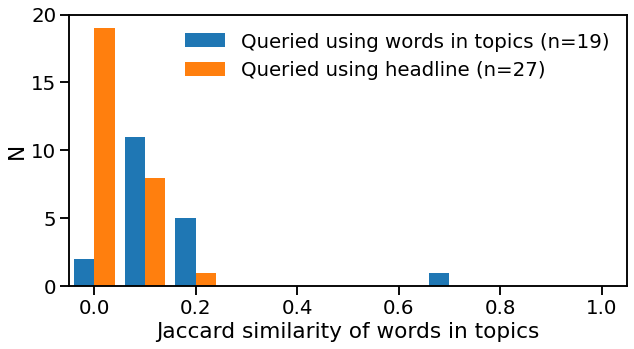

<Figure size 432x288 with 0 Axes>

In [59]:
alpha_val = 1

plt.figure(figsize=(10,5));
plt.hist([jaccard_sim_queried_articles.reshape(len(jaccard_sim_queried_articles),),
          jaccard_sim_headline_articles.reshape(len(jaccard_sim_headline_articles),)],bins=np.arange(0,1.2,.1)-.05,alpha=alpha_val);
# plt.hist(jaccard_sim_headline_articles,bins=np.arange(0,1.2,.1)-.05,alpha=alpha_val);
# plt.hist(jaccard_sim_random_articles,bins=np.arange(0,1.2,.1)-.05,alpha=alpha_val);
plt.ylabel('N');
plt.xlabel('Jaccard similarity of words in topics')
sns.set_context('talk', font_scale=1.2);
plt.xlim([-.05,1.05])
plt.ylim([0,20])
plt.legend((f'Queried using words in topics (n={len(urls_queried)})',
            f'Queried using headline (n={len(urls_headline)})'),framealpha=0)
# plt.xticks(rotation=90);
plt.show();
plt.clf();

/Users/sagarsetru/anaconda3/envs/debiaser/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


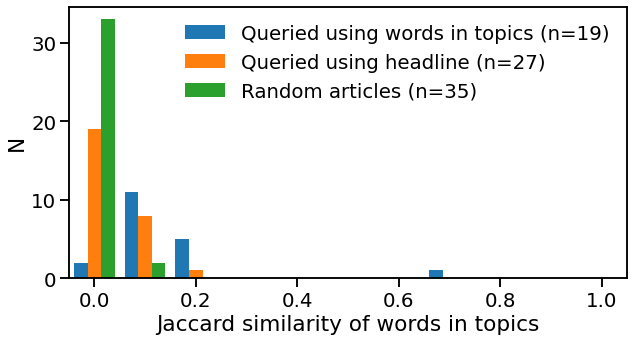

<Figure size 432x288 with 0 Axes>

In [56]:
alpha_val = 1

plt.figure(figsize=(10,5));
plt.hist([jaccard_sim_queried_articles.reshape(len(jaccard_sim_queried_articles),),
          jaccard_sim_headline_articles.reshape(len(jaccard_sim_headline_articles),),
          jaccard_sim_random_articles.reshape(len(jaccard_sim_random_articles),)],bins=np.arange(0,1.2,.1)-.05,alpha=alpha_val);
# plt.hist(jaccard_sim_headline_articles,bins=np.arange(0,1.2,.1)-.05,alpha=alpha_val);
# plt.hist(jaccard_sim_random_articles,bins=np.arange(0,1.2,.1)-.05,alpha=alpha_val);
plt.ylabel('N');
plt.xlabel('Jaccard similarity of words in topics')
sns.set_context('talk', font_scale=1.2);
plt.xlim([-.05,1.05])
plt.legend((f'Queried using words in topics (n={len(urls_queried)})',
            f'Queried using headline (n={len(urls_headline)})',
            f'Random articles (n={len(urls_random)})'),framealpha=0)
# plt.xticks(rotation=90);
plt.show();
plt.clf();

We see that searching with the words in topics gave fewer, yet more similar results than searching with the headline.

On the other hand, searching with the headline gave more results, but the results tended to score less similarly. 

We see that the queried articles tend to have more similar topic words, as measured by Jaccard similarity, to the initial article than random articles.